In [45]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create "honeycomb" model geometry

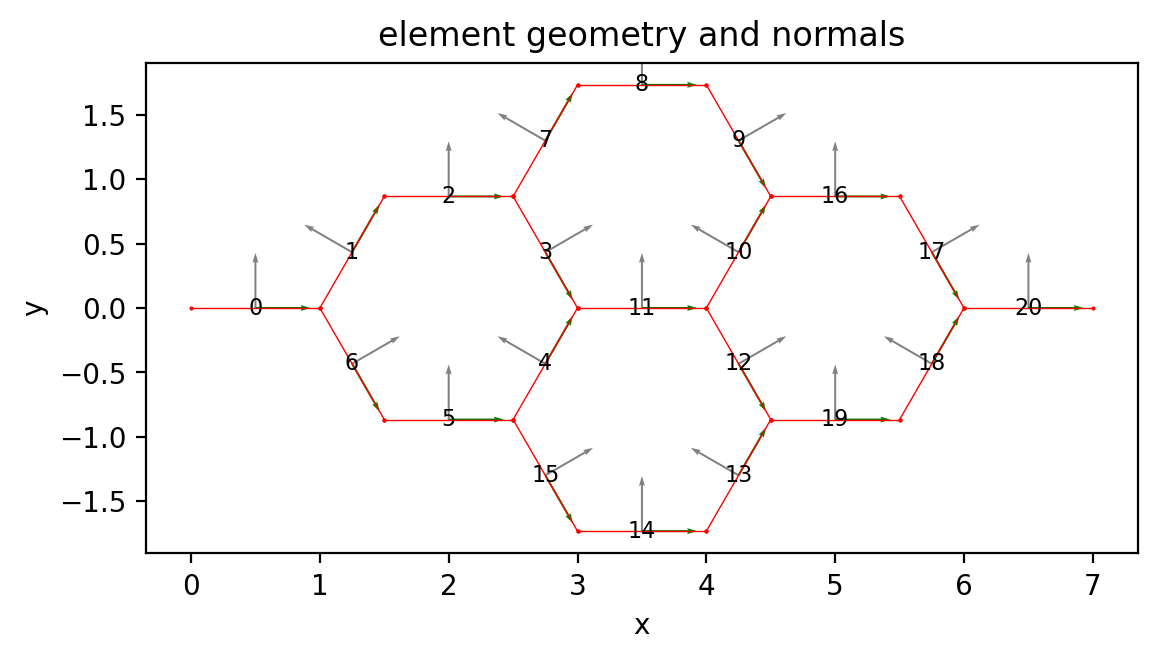

In [46]:
# Honeycomb geometry
dx = np.cos(np.deg2rad(60))
dy = np.sin(np.deg2rad(60))
els = bemcs.initialize_els()

els.x1 = np.array(
    [
        0,
        1,
        1 + dx,
        2 + dx,
        2 + 2 * dx,
        2 + dx,
        1 + dx,
        2 + dx,
        2 + 2 * dx,
        3 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        3 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        2 + 2 * dx,
        3 + 3 * dx,
        4 + 3 * dx,
        4 + 4 * dx,
        4 + 3 * dx,
        4 + 4 * dx,
    ]
)
els.y1 = np.array(
    [
        0,
        0,
        dy,
        dy,
        0,
        -dy,
        -dy,
        dy,
        2 * dy,
        2 * dy,
        dy,
        0,
        0,
        -dy,
        -2 * dy,
        -2 * dy,
        dy,
        dy,
        0,
        -dy,
        0,
    ]
)
els.x2 = np.array(
    [
        1,
        1 + dx,
        2 + dx,
        2 + 2 * dx,
        2 + dx,
        1 + dx,
        1,
        2 + 2 * dx,
        3 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        2 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        2 + 2 * dx,
        2 + dx,
        4 + 3 * dx,
        4 + 4 * dx,
        4 + 3 * dx,
        3 + 3 * dx,
        5 + 4 * dx,
    ]
)
els.y2 = np.array(
    [
        0,
        dy,
        dy,
        0,
        -dy,
        -dy,
        0,
        2 * dy,
        2 * dy,
        dy,
        0,
        0,
        -dy,
        -2 * dy,
        -2 * dy,
        -dy,
        dy,
        0,
        -dy,
        -dy,
        0,
    ]
)

bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# Set slip rates at element centroids
Currently this is just a linear gradient in slip with $y$.  Not sure if that's interesting enough but probably a good starting place.

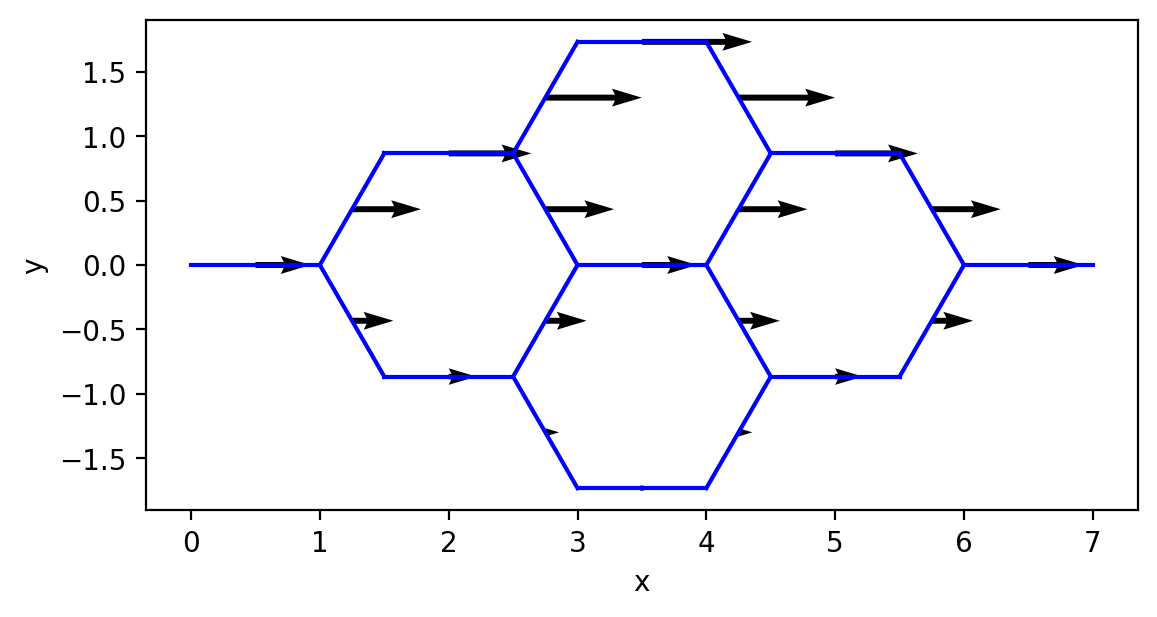

In [47]:
x_slips = np.zeros(n_els)
y_slips = np.zeros(n_els)
x_slips[0] = 0.500
x_slips[1] = 0.625
x_slips[2] = 0.750
x_slips[3] = 0.625
x_slips[4] = 0.375
x_slips[5] = 0.250
x_slips[6] = 0.375
x_slips[7] = 0.875
x_slips[8] = 1.000
x_slips[9] = 0.875
x_slips[10] = 0.625
x_slips[11] = 0.500
x_slips[12] = 0.375
x_slips[13] = 0.125
x_slips[14] = 0.000
x_slips[15] = 0.125
x_slips[16] = 0.750
x_slips[17] = 0.625
x_slips[18] = 0.375
x_slips[19] = 0.250
x_slips[20] = 0.500

# x_slips = -(els.x_centers - np.mean(els.x_centers)) * 0.8
# y_slips = -(els.y_centers) * 0.5

plt.figure()
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "-b")
plt.quiver(els.x_centers, els.y_centers, x_slips, y_slips, width=0.006)
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
plt.show()

# Automatic node labelling scheme
We need to know the IDs of all the open nodes, 2-overlap and triple junction nodes. This is useful for when we apply boundary conditions and setup the matrix equations.

In [48]:
# first find all unique points
points = np.zeros((2 * n_els, 2))
x1y1 = np.vstack((els.x1, els.y1)).T
x2y2 = np.vstack((els.x2, els.y2)).T
points[0::2, :] = x1y1
points[1::2, :] = x2y2
nvec = np.vstack((els.x_normals, els.y_normals)).T
xmid = np.copy(els.x_centers)
ymid = np.copy(els.y_centers)
unique_points, id_unique = np.unique(points, axis=0, return_index=True)

# Find number of open, 2-overlap & triple junction nodes
index_matrix1 = []
index_matrix2 = []
index_matrix3 = []
for i in range(len(unique_points)):
    pts = unique_points[i, :].reshape(1, -1)

    # Which element(s) contains this point
    id1 = np.where(np.all(pts == x1y1, axis=1))
    id2 = np.where(np.all(pts == x2y2, axis=1))

    # The negative signs are for the triple junction equations
    # s_1 + s_2 + s_3 = 0 with the negative sign going to any 2 elements that are both id1 or id2
    if np.size(id1) == 2:
        id_combo = np.hstack((-id1[0] * 3, id2[0] * 3 + 2))
    elif np.size(id2) == 2:
        id_combo = np.hstack((id1[0] * 3, -(id2[0] * 3 + 2)))
    else:
        id_combo = np.hstack((id1[0] * 3, id2[0] * 3 + 2))

    if np.size(id_combo) == 1:
        index_matrix1.append(id_combo)
    elif np.size(id_combo) == 2:
        index_matrix2.append(id_combo)
    elif np.size(id_combo) == 3:
        index_matrix3.append(id_combo)
    else:
        print(id_combo)
        raise ValueError("Cannot deal with more than 3 lines at a node")

print("Number of open nodes =", len(index_matrix1))
print(":", index_matrix1)
print("Number of 2-overlap nodes =", len(index_matrix2))
print(":", index_matrix2)
print("Number of triple junctions =", len(index_matrix3))
print(":", index_matrix3)

N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_matrix1)  # open node equations
N_i = 4 * len(index_matrix2)  # overlapping node equations
N_t = 6 * len(index_matrix3)  # triple junction equations

Number of open nodes = 2
: [array([0]), array([62])]
Number of 2-overlap nodes = 8
: [array([15, 20]), array([6, 5]), array([42, 47]), array([24, 23]), array([39, 44]), array([27, 26]), array([54, 59]), array([51, 50])]
Number of triple junctions = 8
: [array([ -3, -18,   2]), array([-12, -45,  17]), array([ -9, -21,   8]), array([ 33, -11, -14]), array([-30, -36,  35]), array([ 57, -38, -41]), array([ 48, -29, -32]), array([ 60, -53, -56])]


# Boundary Conditions
Here we implement the various boundary conditions as a big vector that goes in the right hand side of the Integral equations. The convention we follow is:
- BCs at node centers
- BCs at open nodes
- BCs at interior 2-overlap nodes
- BCs at triple junctions 

In [49]:
# Nequations = N_c + N_o + N_i + N_t
Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

BC_c[0::2, 0] = x_slips
BC_c[1::2, 0] = y_slips
# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

# Design Matrix System 
Here we implement various boundary conditions at the different types of nodes we have
- At element centers, we implement imposed slip boundary conditions
- At open nodes, we force slip to be 0
- At 2-overlap (interior) nodes we have continuity & smoothness of slip
- At triple junctions, we are currently implementing 2 equations for conservation of slip and 4 equations for smoothness

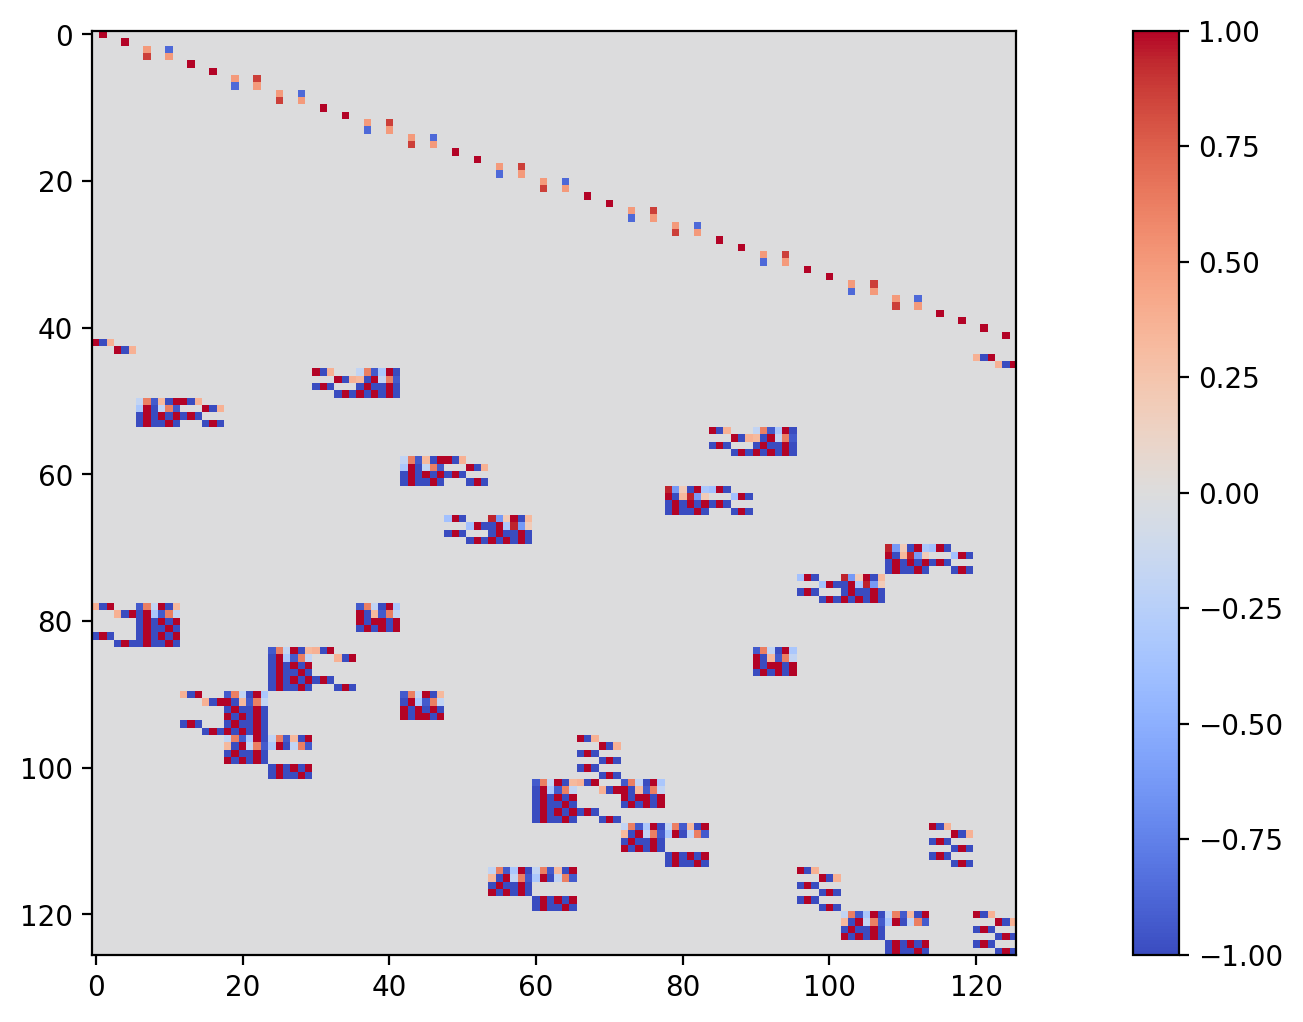

In [50]:
# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
matrix_system_o = np.zeros((N_o, Nunknowns))
matrix_system_i = np.zeros((N_i, Nunknowns))
matrix_system_t = np.zeros((N_t, Nunknowns))

# populate matrix_system for central nodes
# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, flag="node"
)
matrix_system_c[0::2, :] = matrix_slip[2::6, :]  # x component
matrix_system_c[1::2, :] = matrix_slip[3::6, :]  # y component

# Linear operator for open nodes
for i in range(int(N_o / 2)):
    id1 = index_matrix1[i]  # node number
    matrix_system_o[2 * i, :] = matrix_slip[2 * id1, :]  # x component
    matrix_system_o[2 * i + 1, :] = matrix_slip[2 * id1 + 1, :]  # y component

# Linear operator for overlapping nodes
for i in range(int(N_i / 4)):
    idvals = index_matrix2[i]  # node number
    # continuity condition
    matrix_system_i[4 * i, :] = (
        matrix_slip[2 * idvals[0], :] - matrix_slip[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 1, :] = (
        matrix_slip[2 * idvals[0] + 1, :] - matrix_slip[2 * idvals[1] + 1, :]
    )  # y
    # smoothing constraints
    matrix_system_i[4 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y

# Linear operator for triple junction nodes
for i in range(int(N_t / 6)):
    id1 = index_matrix3[i]
    idvals = np.abs(id1)

    id_neg = idvals[id1 < 0]  # node number that need to be subtracted in TJ kinematics
    id_pos = idvals[id1 >= 0]  # node numbers that need to be added
    # triple junction kinematics equations
    if len(id_neg) == 2:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos, :]
            - matrix_slip[2 * id_neg[0], :]
            - matrix_slip[2 * id_neg[1], :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos + 1, :]
            - matrix_slip[2 * id_neg[0] + 1, :]
            - matrix_slip[2 * id_neg[1] + 1, :]
        )  # y component
    else:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos[0], :]
            + matrix_slip[2 * id_pos[1], :]
            - matrix_slip[2 * id_neg, :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos[0] + 1, :]
            + matrix_slip[2 * id_pos[1] + 1, :]
            - matrix_slip[2 * id_neg + 1, :]
        )  # y component

    # smoothing constraints (2 nodes at a time)
    matrix_system_t[6 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_t[6 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y
    matrix_system_t[6 * i + 4, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[2], :]
    )  # x
    matrix_system_t[6 * i + 5, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[2] + 1, :]
    )  # y

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

# plot design matrix
plt.figure(figsize=(15, 6))
plt.imshow(matrix_system, cmap="coolwarm")
plt.colorbar()
plt.clim(-1, 1)
plt.show()

# Solve system of equations

In [51]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

Linear Operator Condition Number: 43.7021131594718


# Plot displacements and stresses in the medium

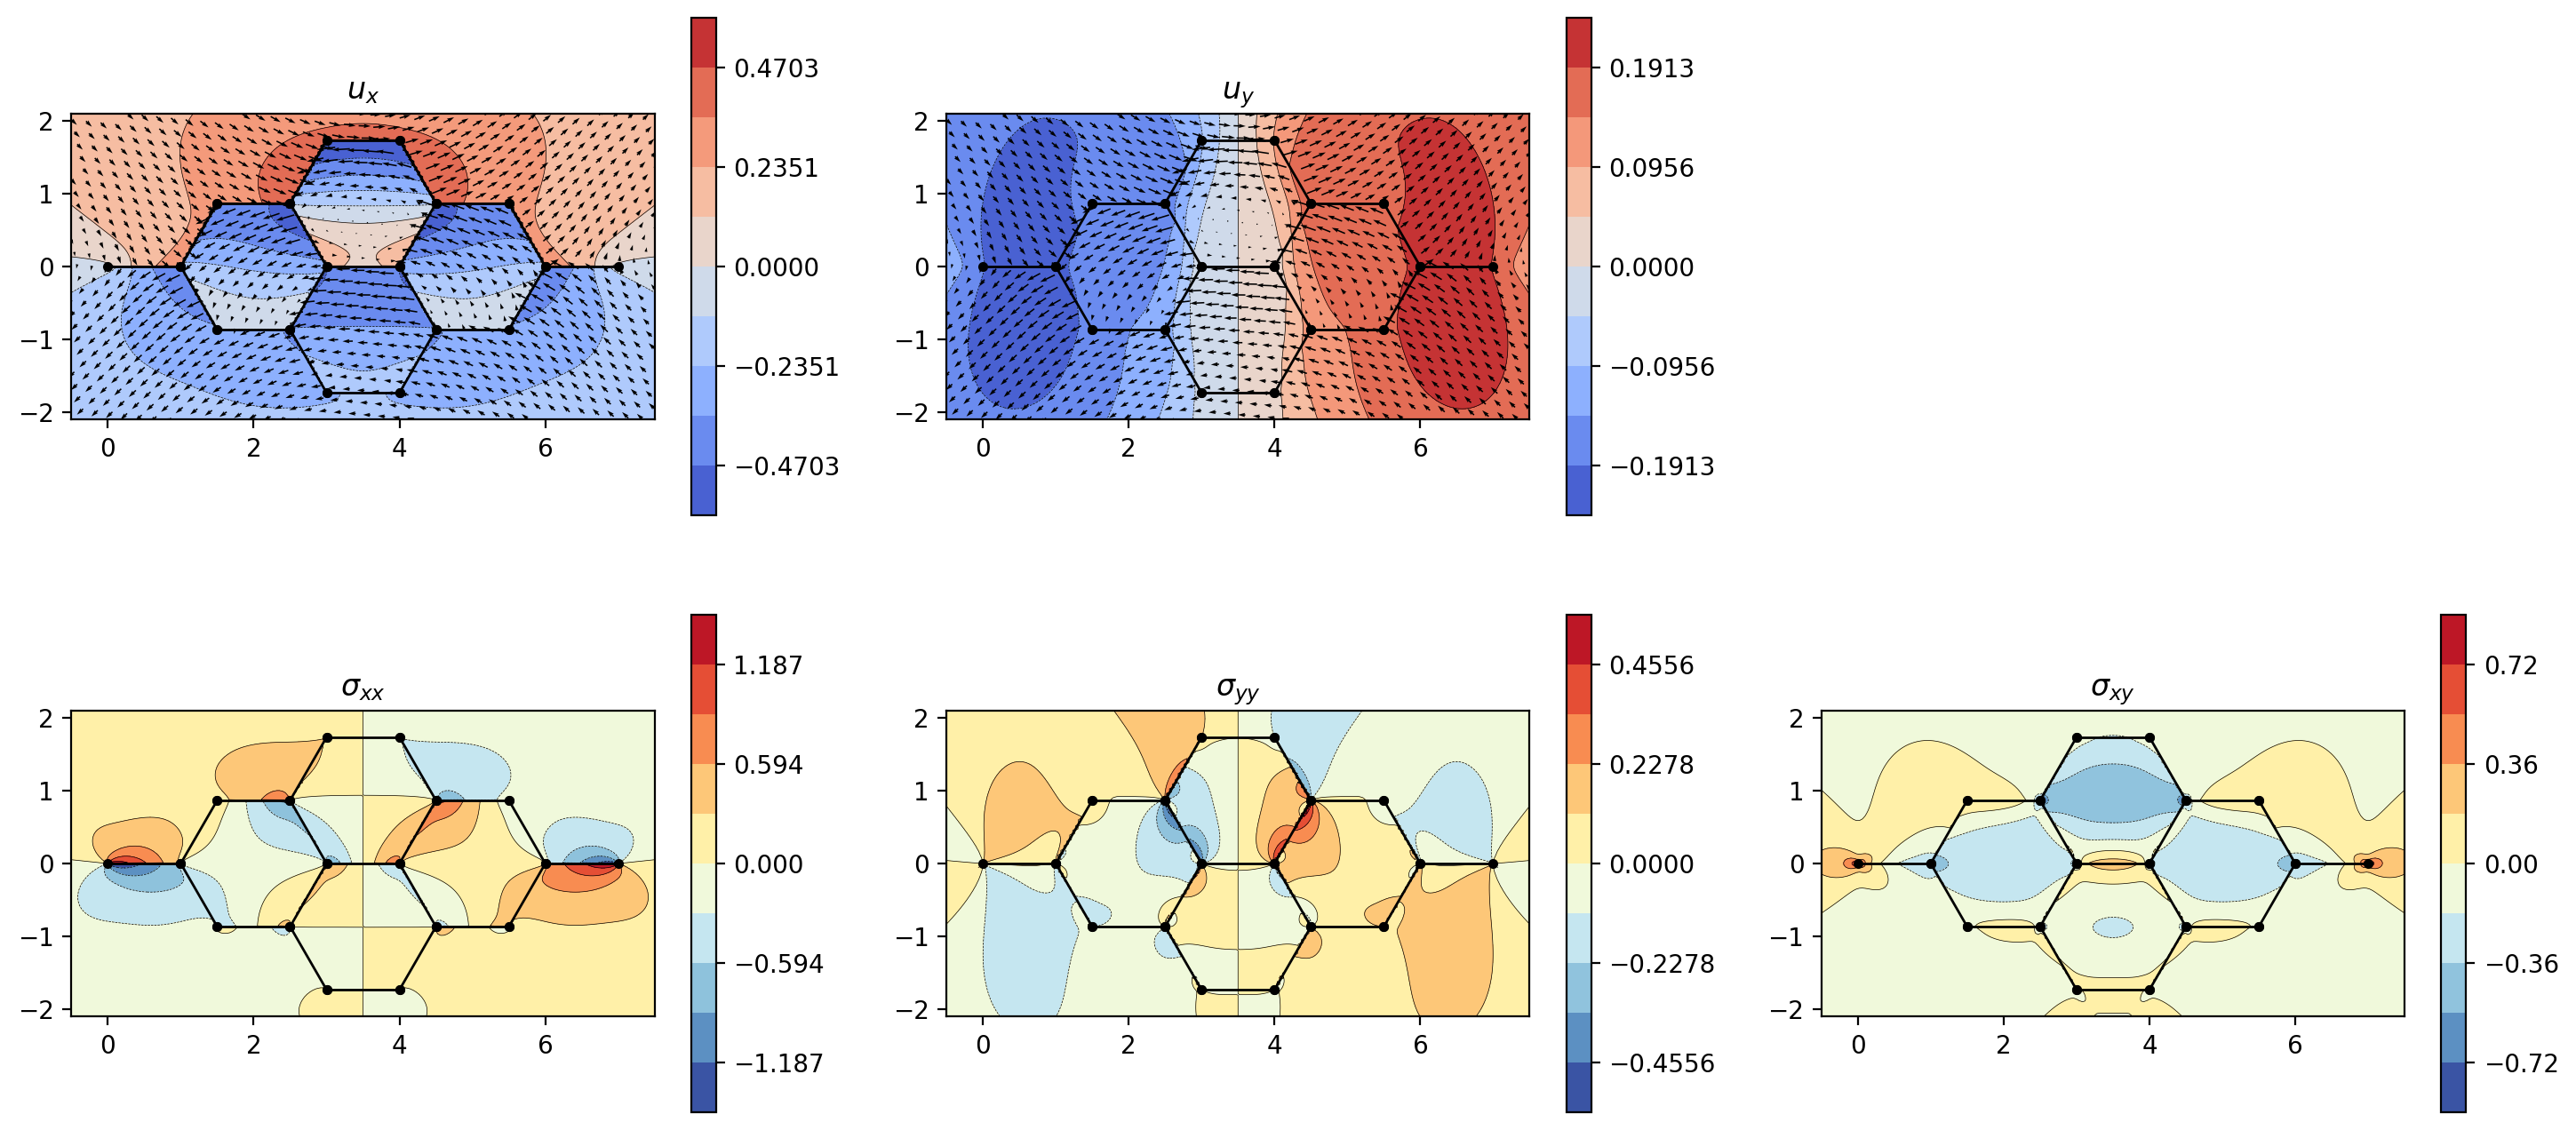

In [52]:
# Elastic parameters
mu = 1
nu = 0.25

# Observation points
n_obs = 200
x_obs = np.linspace(-0.5, 7.5, n_obs)
y_obs = np.linspace(-2.1, 2.1, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Compute displacement and stresses (we will plot it later)
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=39
)

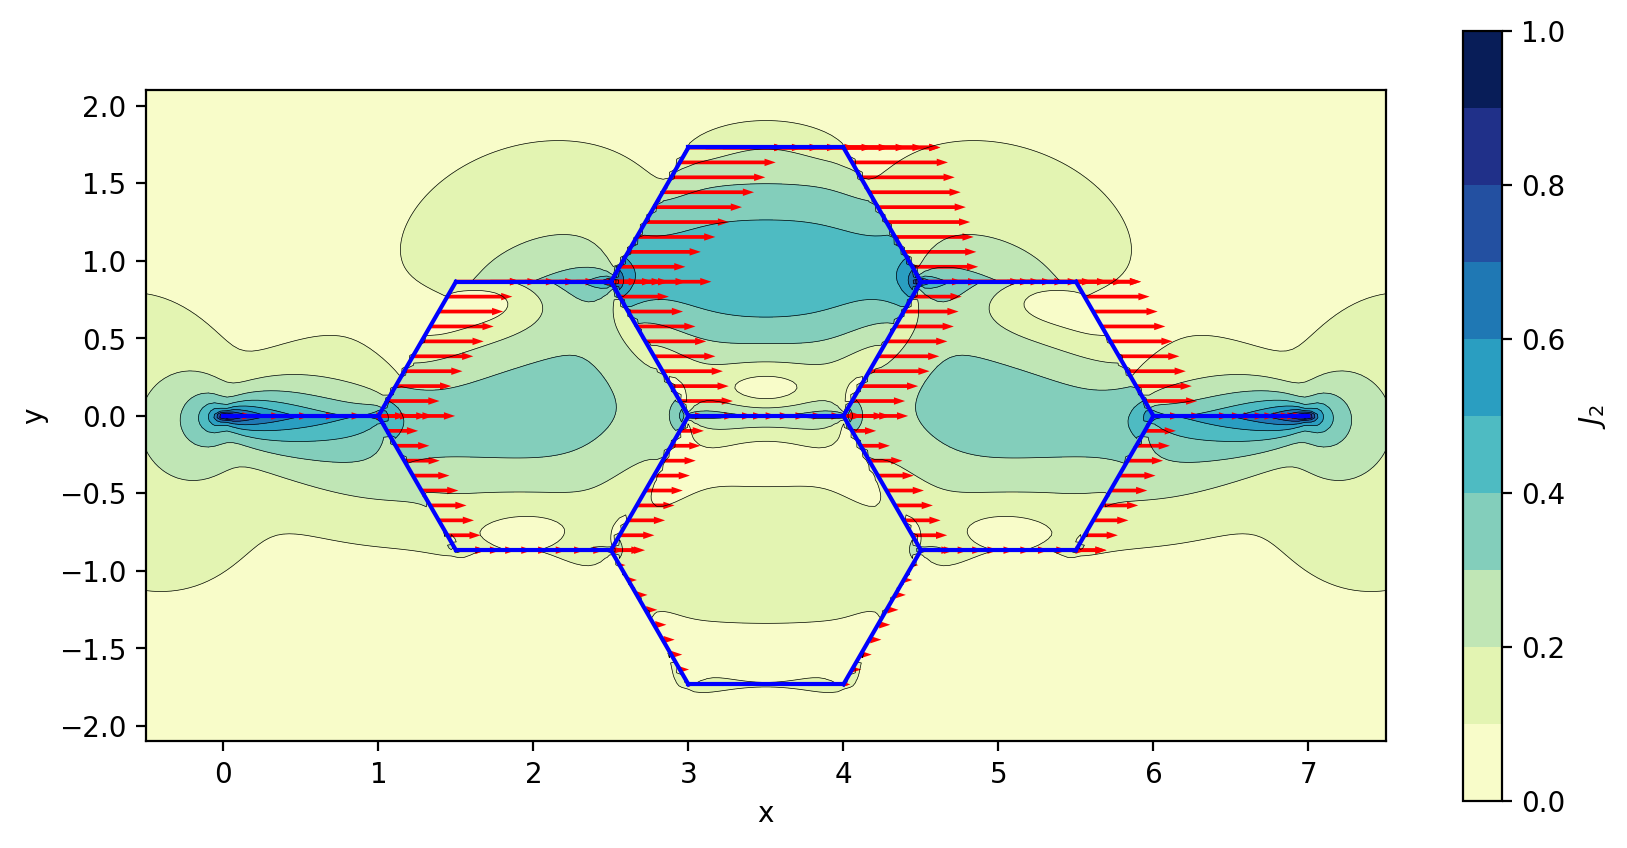

In [53]:
plt.figure(figsize=(10, 5))
# Plot J2 invariant
toplot = np.sqrt(0.25 * (sxx - syy) ** 2 + sxy**2)  # J2 invariant
maxval = np.max(toplot)
levels = np.linspace(0, 1, 11)
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot.reshape(n_obs, n_obs),
    cmap="YlGnBu",
    levels=levels,
    vmin=0,
    vmax=maxval,
)
plt.colorbar(img, label="$J_2$")
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot.reshape(n_obs, n_obs),
    linewidths=0.25,
    colors="k",
    levels=levels,
)

# Calculate slip values over each fault element
x_plot, y_plot, slip_discretized_x, slip_discretized_y = bemcs.get_slipvector_on_fault(
    els, quadratic_coefs[:, 0], 10
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "-b")
plt.quiver(
    x_plot,
    y_plot,
    slip_discretized_x,
    slip_discretized_y,
    width=0.003,
    headwidth=2,
    headlength=3,
    headaxislength=3,
    color="r",
)
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
plt.show()